<a href="https://colab.research.google.com/github/CRekkaran/Instant-Background/blob/master/SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 2.1MB/s 
     |████████████████████████████████| 276kB 6.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post200513-cp36-none-any.whl size=40893 sha256=97feec2eec01d14de5b597a0641c6ff41bb418d8fbc41691a36505fdf437d895
  Stored in directory: /root/.cache/pip/wheels/a2/f6/77/551770c4b8cd75e9335cd0acf59c08d60a8684048b19da6702
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=7803d27240f46951a30b281554ff2a9199506d283272e1514c951c5bf9ebc4c5
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built fvcore pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in

In [0]:
import torch, torchvision
import detectron2
# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

In [0]:
from detectron2.modeling import build_model
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import  GenericMask
from detectron2.data import MetadataCatalog

In [0]:
from detectron2.config import get_cfg
cfg = get_cfg()
model = build_model(cfg)

In [5]:
!wget https://magazine.utoronto.ca/wp-content/uploads/2016/08/Selfie_480-1200x630-c-default.jpg
!wget https://static.toiimg.com/photo/71744566.cms
!wget https://i0.wp.com/cdn-prod.medicalnewstoday.com/content/images/articles/325/325984/person-taking-a-selfie.jpg?w=1155&h=1734

--2020-05-20 18:42:30--  https://magazine.utoronto.ca/wp-content/uploads/2016/08/Selfie_480-1200x630-c-default.jpg
Resolving magazine.utoronto.ca (magazine.utoronto.ca)... 142.1.176.100
Connecting to magazine.utoronto.ca (magazine.utoronto.ca)|142.1.176.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118563 (116K) [image/jpeg]
Saving to: ‘Selfie_480-1200x630-c-default.jpg’

Selfie_480-1200x630 100%[===================>] 115.78K   219KB/s    in 0.5s    

2020-05-20 18:42:31 (219 KB/s) - ‘Selfie_480-1200x630-c-default.jpg’ saved [118563/118563]

--2020-05-20 18:42:34--  https://static.toiimg.com/photo/71744566.cms
Resolving static.toiimg.com (static.toiimg.com)... 104.94.57.5, 2600:1417:76:28d::216f, 2600:1417:76:297::216f
Connecting to static.toiimg.com (static.toiimg.com)|104.94.57.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189927 (185K) [image/jpeg]
Saving to: ‘71744566.cms’

71744566.cms        100%[===================>] 

In [6]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:16, 11.1MB/s]                           


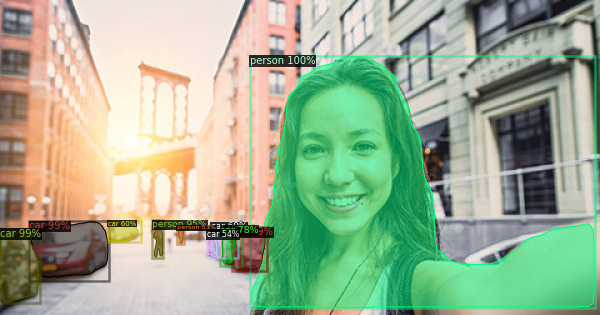

In [8]:
path = '/content/'
im = cv2.imread(path + '2.jpg')
output = predictor(im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
v = v.draw_instance_predictions(output["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

<h2>Semantic segmentation of humans only</h2>

**def union_masks(Visualizers.GenericMask.mask1, Visualizers.GenericMask.mask2) => Taking union of human masks**

In [0]:
def union_masks(im1, im2):
  assert(im1.shape == im2.shape)
  # r, c = im1.shape
  # res = im1
  # for i in range(r):
  #   for j in range(c):
  #     if(im1[i][j]==1 or im2[i][j]==1):
  #       res[i][j] = 1
  #     else:
  #       res[i][j] = 0
  # return res
  return im1 | im2

# Testing def union_masks
# print(union_masks(np.array([[0,1], [0,0]]), np.array([[1,0], [0,1]])))

In [0]:
def return_attributes(path):
  im = cv2.imread(path)
  output = predictor(im)

  SCORE_THRESHOLD = 0.7
  AREA_FRACTION_THRESHOLD = 0.1

  instances = output['instances']

  # storing attributes
  predictions = output["instances"].to("cpu")
  boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
  scores = predictions.scores if predictions.has("scores") else None
  classes = predictions.pred_classes if predictions.has("pred_classes") else None
  # labels = du._create_text_labels(classes, scores, v.metadata.get("thing_classes", None))
  keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.3)
  if predictions.has("pred_masks"):
      masks = np.asarray(predictions.pred_masks)
      masks = [GenericMask(x, v.output.height, v.output.width) for x in masks]
  else:
    masks = None

  humans = (classes==0).nonzero().reshape(-1).numpy()
  temp = []
  for i in range(len(humans)):
    if(scores[humans[i]]>SCORE_THRESHOLD and masks[i].area()/(im.shape[0] * im.shape[1])>AREA_FRACTION_THRESHOLD):
      temp.append(humans[i])

  humans = temp

  human_masks = []

  for i in range(len(masks)):
    # if(i in humans):
    if(i in humans):
      human_masks.append(masks[i])

  # changing all boxes -> human boxes
  a = boxes.tensor.numpy()
  aa = np.array([])
  for i in humans:
    aa = np.append(aa, a[i])
  r, c = len(humans), (aa.shape[0]//len(humans))
  boxes.tensor = torch.from_numpy(aa.reshape(r, c))

  return im, human_masks, boxes

**This cell crops out the human box**

In [0]:
# boxes_array => a tuple containing x0, y0, x1, y1 coordinates, where x0 and y0 are the coordinates of the image's top left corner. x1 and y1 are the coordinates of the image's bottom right corner.
def bound_human_boxes(boxes):
  boxes_array = boxes.tensor.numpy()
  human_crop_images = []
  for i in boxes_array:
    x0, y0, x1, y1 = [int(x) for x in i]
    width = x1 - x0
    height = y1 - y0
    human_crop_images.append(im[y0:y1, x0:x1, :])
    # cv2_imshow(im[y0:y1, x0:x1, :])

  return human_crop_images

**def remove_bg(image, human_masks) => removes backgroung excepts all humans**

In [0]:
def return_union_mask(im, human_masks):
  union_mask = human_masks[0].mask
  if len(human_masks)>1:
    for i in range(1, len(human_masks)):
      union_mask = union_masks(union_mask, human_masks[i].mask)
  return union_mask

def remove_bg(im, union_mask):
  temp = im
  h1_mask = union_mask
  for i in range(h1_mask.shape[0]):
    for j in range(h1_mask.shape[1]):
      if(h1_mask[i][j]==0):
        temp[i][j][:] = 255
  return temp

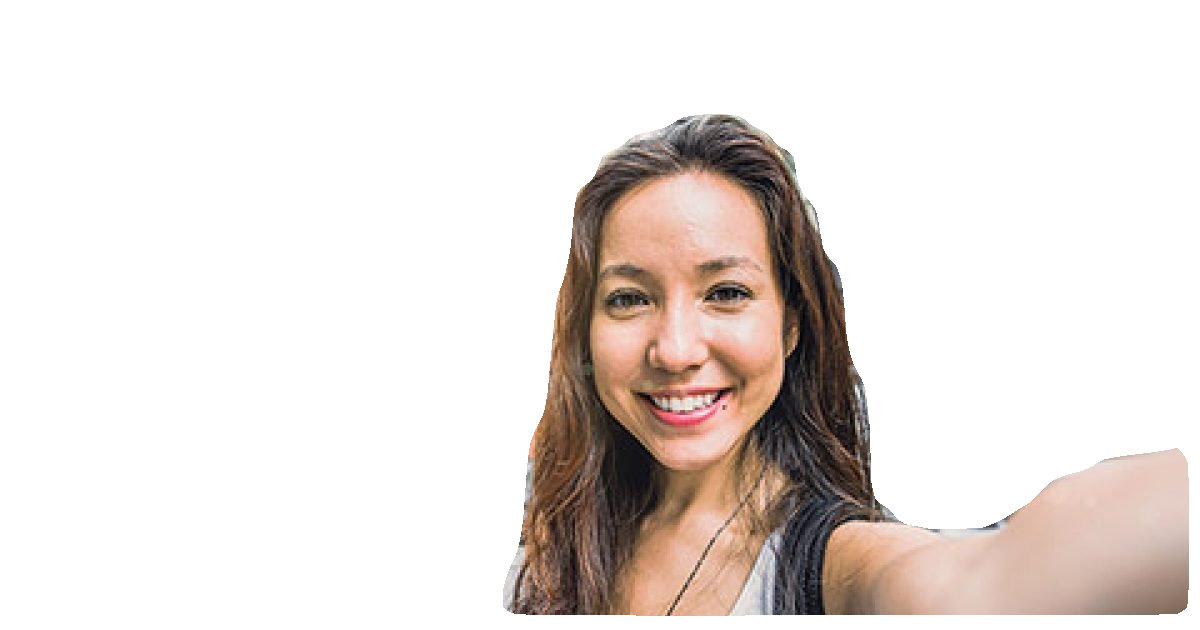

In [14]:
# how-to call above functions:
path = '/content/'
#returns necessary attrbutes and results from model output
im, human_masks, boxes = return_attributes(path+'2.jpg')

# list of singular human images
final_images = bound_human_boxes(boxes)

# final mask => NxM bool matrix : value is 1 if human is present on the pixel
final_mask = return_union_mask(im, human_masks)

# Remove background and show the resultant image 
cv2_imshow(remove_bg(im, final_mask))

In [0]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from keras import backend as K
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [0]:
def inttoEmotion(num):
  if(num[0][0]==1):
    return 'anger'
  if(num[0][1]==1):
    return 'surprise'
  if(num[0][2]==1):
    return 'disgust'
  if(num[0][3]==1):
    return 'fear'
  if(num[0][4]==1):
    return 'neutral'
  if(num[0][5]==1):
    return 'happiness'
  if(num[0][6]==1):
    return 'sadness'
  if(num[0][7]==1):
    return 'contempt'
  return '[error] Bad prediction'

In [0]:
# dimensions of our images
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='valid', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

# load the model we saved
model.load_weights('./model_emotion.h5')

In [68]:
em = cv2.resize(remove_bg(im, final_mask), (128, 128)).reshape(1, 128, 128, 3)
print(inttoEmotion(model.predict(em)))

happiness
